In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [41]:
img1 = 255 - cv2.imread('../images/trimmed_queries_divorce/divorce/G/0_extraction_doc_0_line_20_char_36_original_trim.png', 0) 
img2 = 255 - cv2.imread('../images/trimmed_queries_divorce/queries/G/extraction_doc_13_line_7_char_17_original_trim.png', 0)
img3 = 255 - cv2.imread('../images/trimmed_queries_divorce/divorce/G/1_extraction_doc_5_line_35_char_49_original_trim.png', 0)

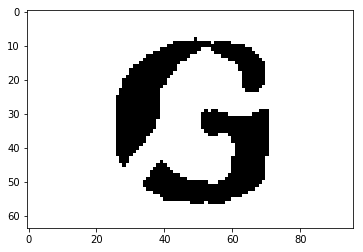

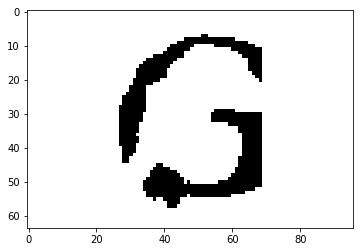

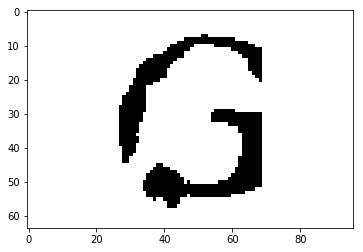

In [176]:
# helper function used to specify the corners of a rectangle with specified dimensions, orientation,
# and location
def create_rectangle(center, height, width, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-1*np.sin(angle), np.cos(angle)]])
    corners = np.array([[width/2.0, width/2.0, -1*width/2.0, -1*width/2.0],
                       [height/2.0, -1*height/2.0, -1*height/2.0, height/2.0]])
    return np.transpose(np.matmul(rot_mat, corners) + np.array([[center[0]], [center[1]]])).astype(np.int32)

# function designed to add a "bar break" (i.e., delete a band of pixels) to an input G
# default parameters are designed to align with an example of the break that I found in the images
# but different parameters can be used to generate breaks in other locations on the G
def bar_break(image, center = [38, 40], height = 7, width = 25, angle = 0.9):
    ar = np.zeros((64, 96)) # create a black background
    rect = create_rectangle(center, height, width, angle) # get rectangle corners
    cv2.fillConvexPoly(ar, rect, 255) # draw the rectangle in white
    
    # now delete the area covered by the rectangle and return the newly broken G
    imgnew = image - ar
    imgnew[np.where(imgnew < 0)] = 0
    return 255 - imgnew

# testing out the break on non-defective G
imnew = bar_break(img1)
plt.imshow(imnew, cmap="gray")
plt.show()

# the next two images show a real example of the break and show that the default parameters do
# not change this example
imnew2 = bar_break(img2)
plt.imshow(imnew2, cmap="gray")
plt.show()

plt.imshow(255 - img2, cmap="gray")
plt.show()


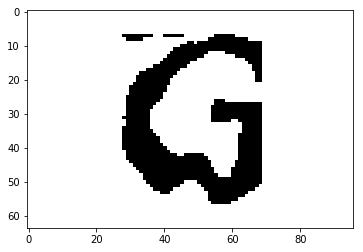

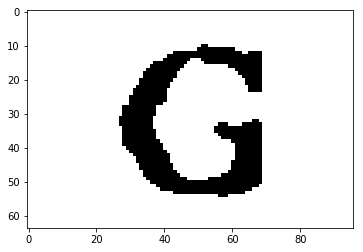

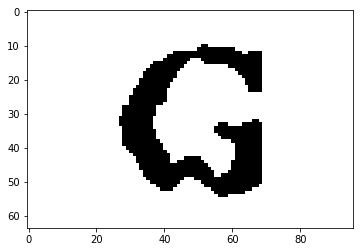

In [44]:
from skimage.draw import bezier_curve
from scipy.ndimage.morphology import binary_fill_holes

# plot an example of the bend defect we are trying to capture
plt.imshow(255 - img3, cmap="gray")
plt.show()

# plot the non-defective G that we want to bend
plt.imshow(255 - img1, cmap="gray")
plt.show()

# function to add a bend to the base of the G
# currently does not allow bends to be added to other locations on the G
# default parameters might not work for shifted images
def bend_base(image, start_col = 42, end_col = 55, start_row = 40, end_row = 60):
    # begin by deleting the area we will add the bend to
    imnew = image.copy()
    for row in range(start_row, end_row):
        for col in range(start_col, end_col):
            imnew[row, col] = 0
    
    # the y-axis locations of the top section of the G falling into the box we deleted
    # this is roughly where we will add the upper curve of the bend
    g_start_row_left = np.min(np.where(image[start_row:end_row, start_col] > 0)) + start_row
    g_end_row_left = np.max(np.where(image[start_row:end_row, start_col] > 0)) + start_row
    
    # the y-axis locations of the bottom section of the G falling into the box we deleted
    # this is roughly where we will add the lower curve of the bend
    g_start_row_right = np.min(np.where(image[start_row:end_row, end_col] > 0)) + start_row
    g_end_row_right = np.max(np.where(image[start_row:end_row, end_col] > 0)) + start_row

    # now draw two bezier curves that form the boundaries of the bend
    rr, cc = bezier_curve(g_start_row_left, start_col, g_start_row_left - 3, start_col + 8,
                         g_start_row_right, end_col, 2)
    imnew[rr, cc] = 255

    rr, cc = bezier_curve(g_end_row_left, start_col, g_end_row_left - 6, start_col + 4,
                         g_end_row_right, end_col, 2)
    imnew[rr, cc] = 255
    
    # finally, fill in the gap between the boundary curves to get the bent G
    imnew = binary_fill_holes(imnew)
    
    return imnew

imnew = bend_base(img1)

        
plt.imshow(255 - imnew, cmap="gray")
plt.show()